#Leg Circumduction Analysis

The purpose of this notebook is to perform the analysis to determine if leg circumduction is reduced with either the PPAFO or the AFO compared with the participant's own shoes

In [1]:
%matplotlib inline
%precision 3

import numpy as np
import ReadCsvs as rc
import thinkstats2
import thinkplot
import JointAngFuncs as jaf
import math
import KneeAngleHypTest as ht

/Users/jpoh/anaconda/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /Users/jpoh/anaconda/lib/python2.7/argparse.pyc, but /Users/jpoh/anaconda/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


In [2]:
AFO, PPAFO, Shoes=rc.ReadGaitData()

Sub001_6MW_AFO_0001.mat
Sub001_6MW_AFO_0002.mat
Sub001_6MW_AFO_0003.mat
Sub001_6MW_AFO_0004.mat
Sub001_6MW_AFO_0005.mat
Sub001_6MW_AFO_0006.mat
Sub001_6MW_AFO_0007.mat
Sub001_6MW_AFO_0008.mat
Sub001_6MW_AFO_0009.mat
Sub001_6MW_PPAFO_0001.mat
Sub001_6MW_PPAFO_0002.mat
Sub001_6MW_PPAFO_0003.mat
Sub001_6MW_PPAFO_0004.mat
Sub001_6MW_PPAFO_0005.mat
Sub001_6MW_PPAFO_0006.mat
Sub001_6MW_PPAFO_0007.mat
Sub001_6MW_PPAFO_0008.mat
Sub001_6MW_PPAFO_0009.mat
Sub001_6MW_Shoes_0001.mat
Sub001_6MW_Shoes_0002.mat
Sub001_6MW_Shoes_0003.mat
Sub001_6MW_Shoes_0004.mat
Sub001_6MW_Shoes_0005.mat
Sub001_6MW_Shoes_0006.mat
Sub001_6MW_Shoes_0007.mat
Sub001_6MW_Shoes_0008.mat
Sub001_6MW_Shoes_0009.mat
Sub002_6MW_AFO_0001.mat
Sub002_6MW_AFO_0002.mat
Sub002_6MW_AFO_0003.mat
Sub002_6MW_AFO_0004.mat
Sub002_6MW_AFO_0005.mat
Sub002_6MW_AFO_0006.mat
Sub002_6MW_AFO_0007.mat
Sub002_6MW_AFO_0008.mat
Sub002_6MW_AFO_0009.mat
Sub002_6MW_PPAFO_0001.mat
Sub002_6MW_PPAFO_0002.mat
Sub002_6MW_PPAFO_0003.mat
Sub002_6MW_PPAFO_0004.

###Step 1: Compute the relevant joint angles

The markers we will use to compute leg circumduction will be the two ASIS markers as well as the THIGH markers. We start by doing a quick visualization to get a sense of what to expect.

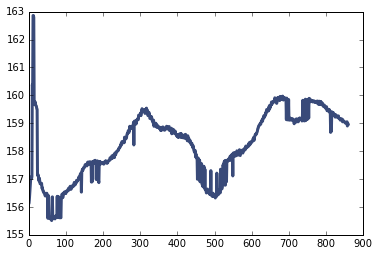

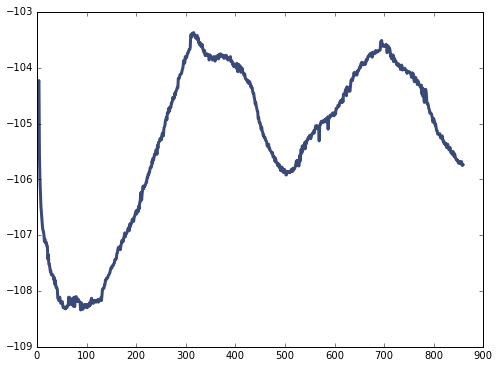

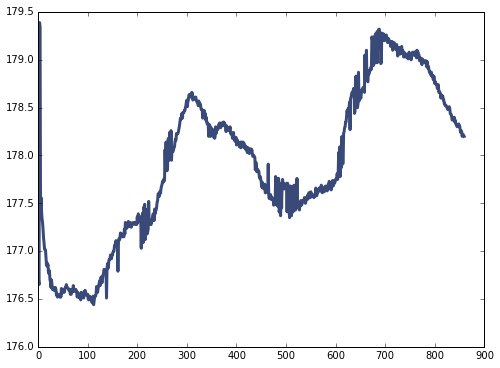

In [3]:
data=AFO[1].GetTrial(1).GetData('y')

thinkplot.Plot(data['R_ASIS'])
thinkplot.Show(legend=False)

thinkplot.Plot(data['L_ASIS'])
thinkplot.Show(legend=False)

thinkplot.Plot(data['R_THIGH'])
thinkplot.Show(legend=False)

 To start, we're going to assume that leg circumduction can be quantified just by how much the leg swings out to the side as the participant walks. For that, we can compute the joint angle observed by looking in the Y-Z plane

### This section redefines the angle calculation scheme for the hip

In [150]:
def HipAngle(AFO, PPAFO, Shoes, fw, pnum, trial, mark1, mark2, mark3):
    """
    This function computes the joint angles for a given participant, trial and set of markers
    
    fw: a string that defines the footwear being studied; Should be either 'AFO', 'PPAFO' or 'Shoes'
    pnum: integer value for the participant number; Should be a number between 1 and 16
    trial: integer value for the trial number being studied; Should be a number between 1 and 10
    mark1: a string that defines the marker label for the marker above the joint being studied
    mark2: a string that defines the marker label for the marker at the joint being studied
    mark3: a string that defines the marker label for the marker below the joint being studied
    
    returns indices (a list of frame numbers), theta_t (a list of joint angles in radians)
    """
    
    theta_t=[]
    
    if fw=='AFO':
        dset=AFO
        
    if fw=='PPAFO':
        dset=PPAFO
        
    if fw=='Shoes':
        dset=Shoes
        
        
    MT_Obj=dset[pnum].GetTrial(trial) #AFO trial 4 for participant 1

#     mark1_x = MT_Obj.x[mark1]
#     mark2_x = MT_Obj.x[mark2]
#     mark3_x = MT_Obj.x[mark3]

    mark1_y = MT_Obj.y[mark1]
    mark2_y = MT_Obj.y[mark2]
    mark3_y = MT_Obj.y[mark3]

    mark1_z = MT_Obj.z[mark1]
    mark2_z = MT_Obj.z[mark2]
    mark3_z = MT_Obj.z[mark3]

#    x_dir_vec=[1,0,0]
#    y_dir_vec=[0,1,0]
#    z_dir_vec=[0,0,1]

    for i in range(len(mark1_y)):
    
#         vec21_x=mark1_x[i]-mark2_x[i]
        vec21_y=mark1_y[i]-mark2_y[i]
        vec21_z=mark1_z[i]-mark2_z[i]
        
#         vec23_x=mark3_x[i]-mark2_x[i]
        vec23_y=mark3_y[i]-mark2_y[i]
        vec23_z=mark3_z[i]-mark2_z[i]
    
        #vec12=[vec21_x, vec21_y, vec21_z]
        vec21=[vec21_y, vec21_z]
        #vec23=[vec23_x, vec23_y, vec23_z]
        vec23=[vec23_y, vec23_z]
    
        #Apply cos (theta) = (A dot B)/(modA modB)
        theta=math.acos((np.dot(vec21, vec23))/((np.linalg.norm(vec21))*(np.linalg.norm(vec23))))
    
        theta_t.append(theta/math.pi*180)
    
    indices=MT_Obj.x.index.get_values()
    
    return indices, theta_t
    
##################
def HipAngleDiff(AFO, PPAFO, Shoes, fw, participant, baselineTrial, WalkTrial, mark1, mark2, mark3, plot=False, reverse=False):
    """
    This function computes the difference between each angle in the walking trial and the median of the baseline trial to
    obtain the change in angle from baseline while the participant is walking.
    
    fw: a string that defines the footwear being studied; Should be either 'AFO', 'PPAFO' or 'Shoes'
    participant: integer value for the participant number; Should be a number between 1 and 16
    WalkTrial: integer value for the trial number of the walking trial being studied; Should be a number between 4 and 10
    mark1: a string that defines the marker label for the marker above the joint being studied
    mark2: a string that defines the marker label for the marker at the joint being studied
    mark3: a string that defines the marker label for the marker below the joint being studied
    
    returns R_angle_changes (list of change in joint angle from baseline in degrees)
    """

    #trial=3

    R_ind_base, R_theta_base=HipAngle(AFO, PPAFO, Shoes, fw, participant, baselineTrial, mark1, mark2, mark3)
    
    cdf1=thinkstats2.Cdf(R_theta_base)
    median_R=cdf1.Percentile(50)
    #print "Baseline Median =", median_R
    
    #trial=WalkTrial
    R_ind, R_theta=HipAngle(AFO, PPAFO, Shoes, fw, participant, WalkTrial, mark1, mark2, mark3)
    
    if plot==True:
        
        thinkplot.Cdf(cdf1)
        thinkplot.Show(legend=False, title='Angle Baseline', xlabel='Angle in degrees', ylabel='CDF')
        thinkplot.Plot(R_ind_base, R_theta_base)
        #thinkplot.Config(ylim=[135,145])
        thinkplot.Show(legend=False, title='Angle Baseline Time Series', xlabel='Time in frames', ylabel='Angle in degrees')

    
        cdf3=thinkstats2.Cdf(R_theta)
        thinkplot.Cdf(cdf3)
        thinkplot.Show(legend=False, title='Walking', xlabel='Angle in degrees', ylabel='CDF')
        thinkplot.Plot(R_ind, R_theta)
        #thinkplot.Config(ylim=[135,145])
        thinkplot.Show(legend=False, title='Walking Time Series', xlabel='Time in frames', ylabel='Angle in degrees')

    R_angle_changes=[]

    if reverse==True:
        for eachang in R_theta:
            R_angle_changes.append(-(eachang-median_R))
    elif reverse==False:
        for eachang in R_theta:
            R_angle_changes.append((eachang-median_R))
        
        
    return R_angle_changes

### This is a debug panel that helps figure out which trial numbers are present across all three footwear conditions

In [183]:
trials1=AFO[5].trials.keys()
trials2=Shoes[5].trials.keys()
trials3=PPAFO[5].trials.keys()
print trials1
print trials2
print trials3

[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13]
[1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13]
[1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 16]


### This section computes the angle differences for all three footwear conditions and plots them over each other so that they can be visualized

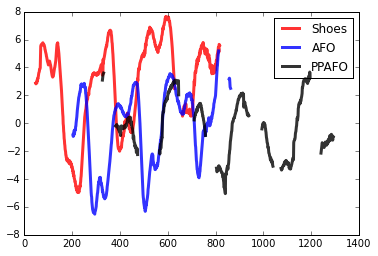

In [199]:
# angles=HipAngle(AFO, PPAFO, Shoes, 'Shoes', 1, 9, 'L_ASIS', 'R_ASIS','R_THIGH' )
# print angles
# thinkplot.Plot(angles[0], angles[1])

angle_diff_shoes=HipAngleDiff(AFO, PPAFO, Shoes, 'Shoes', 11, 2, 5, 'L_TROCH', 'R_TROCH','R_LAT_KNEE', False, True)
angle_diff_AFO=HipAngleDiff(AFO, PPAFO, Shoes, 'AFO', 11, 2, 5, 'L_TROCH', 'R_TROCH','R_LAT_KNEE', False, True)
angle_diff_PPAFO=HipAngleDiff(AFO, PPAFO, Shoes, 'PPAFO', 11, 2, 5, 'L_ASIS', 'R_ASIS','R_THIGH', False, True)

thinkplot.Plot(angle_diff_shoes, label='Shoes', color='red')
thinkplot.Plot(angle_diff_AFO, label='AFO', color='blue')
thinkplot.Plot(angle_diff_PPAFO, label='PPAFO', color='black')
thinkplot.Show(legend=True)

### This section redefines the hypothesis test to add the check for nans before running the actual hypothesis test

In [188]:
def HipCircHypTest(Raw_data1, Raw_data2):
    """
    This function carries out the knee angle hypothesis test and returns the pvalue
    
    Raw_data1: Sequence of data for group 1
    Raw_data2: Sequence of data for group 2
    
    returns: pvalue of the hypothesis test
    """
    
    data1, data2=jaf.RemoveNans(Raw_data1, Raw_data2)

    testmean_1=np.asarray(data1).mean()
    testmean_2=np.asarray(data2).mean()
    
#     print testmean_1
#     print testmean_2
    
    if np.isnan(testmean_1)!=True and np.isnan(testmean_2)!=True:
        #print AFO_angle
        data=(data1, data2)
        hypothesistest=ht.KneeAngleHT(data)
#         print "Actual Observed Effect Size=", hypothesistest.actual

        pvalue=hypothesistest.PValue()
        return pvalue, hypothesistest.actual
#     else:
#         print "Data has returned nan so it will be skipped!"

### This section computes the pvalues for comparing between footwear conditions

In [200]:
pval=HipCircHypTest(angle_diff_shoes, angle_diff_AFO)
print "Actual Observed Effect Size=", pval[1]
print pval[0]

pval2=HipCircHypTest(angle_diff_shoes, angle_diff_PPAFO)
print "Actual Observed Effect Size=", pval2[1]
print pval2[0]

pval3=HipCircHypTest(angle_diff_AFO, angle_diff_PPAFO)
print "Actual Observed Effect Size=", pval3[1]
print pval3[0]

Actual Observed Effect Size= 3.30365293761
0.0
Actual Observed Effect Size= 3.13853279335
0.0
Actual Observed Effect Size= -0.16512014426
0.853


NOTE! Keep in mind that the way we're calculating this is a little weird and so a postive Effect size indicates that the 2nd footwear condition is causing the participant to kick their leg out more than the first footwear condition.

### This section will define a scheme for testing all participants 

In [177]:
def testallcases (AFO, PPAFO, Shoes, pnum, baseline, walking):
    
    angle_diff_shoes=HipAngleDiff(AFO, PPAFO, Shoes, 'Shoes', pnum, baseline, walking, 'L_TROCH', 'R_TROCH','R_LAT_KNEE', False, True)
    angle_diff_AFO=HipAngleDiff(AFO, PPAFO, Shoes, 'AFO', pnum, baseline, walking, 'L_TROCH', 'R_TROCH','R_LAT_KNEE', False, True)
    angle_diff_PPAFO=HipAngleDiff(AFO, PPAFO, Shoes, 'PPAFO', pnum, baseline, walking, 'L_ASIS', 'R_ASIS','R_THIGH', False, True)
    
    pval=HipCircHypTest(angle_diff_shoes, angle_diff_AFO)
#     print pval

    pval2=HipCircHypTest(angle_diff_shoes, angle_diff_PPAFO)
#     print pval2

    pval3=HipCircHypTest(angle_diff_AFO, angle_diff_PPAFO)
#     print pval3

    return [pval, pval2, pval3]

### This section executes the above scheme for all participants

 
For Participant 1
Overlapping trial numbers = set([1, 2, 3, 4, 5, 6, 7, 8, 9])
 
For Participant 2
Overlapping trial numbers = set([1, 2, 3, 4, 5, 6, 7, 8])
 
For Participant  2  Trial  4 , the pvalues were:
Shoes/AFO: (0.0, 3.3665158639755672)
Shoes/PPAFO: (0.0, 6.6968482263101672)
AFO/PPAFO: (0.0, 3.3303323623345999)
 
 
For Participant  2  Trial  5 , the pvalues were:
Shoes/AFO: (0.0, 0.83469692829180708)
Shoes/PPAFO: (0.0, 8.4689260678836433)
AFO/PPAFO: (0.0, 7.6342291395918354)
 
 
For Participant  2  Trial  6 , the pvalues were:
Shoes/AFO: (0.0, 1.7369698043447284)
Shoes/PPAFO: (0.0, 9.8392798978213918)
AFO/PPAFO: (0.0, 8.1023100934766639)
 
 
For Participant  2  Trial  7 , the pvalues were:
Shoes/AFO: (1.0, -1.6263316825765091)
Shoes/PPAFO: (0.0, 5.340327047579879)
AFO/PPAFO: (0.0, 6.9666587301563876)
 
 
For Participant  2  Trial  8 , the pvalues were:
Shoes/AFO: (0.0, 0.65172818419005818)
Shoes/PPAFO: (0.0, 7.9718785971651327)
AFO/PPAFO: (0.0, 7.3201504129750745)
 
 
For Par

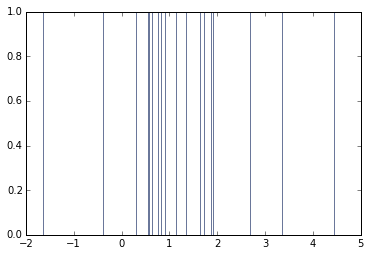

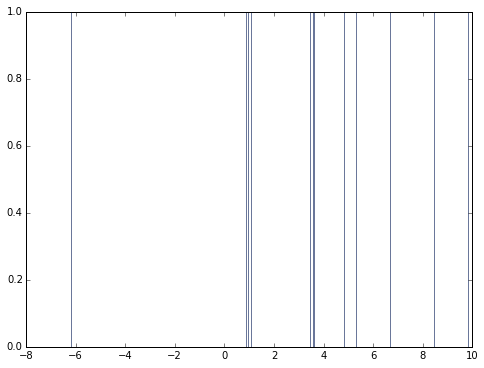

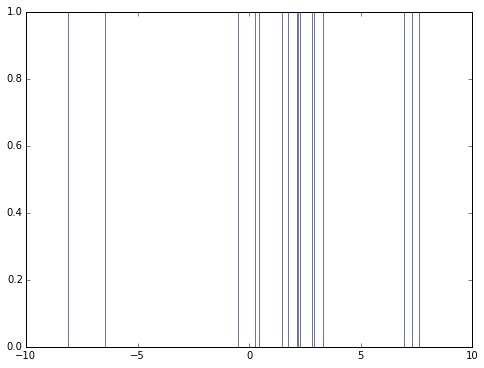

In [202]:
t=dict()
shoesafo=[]
shoesppafo=[]
afoppafo=[]

for participant in AFO.keys():
    afo_keys=AFO[participant].trials.keys()
    ppafo_keys=PPAFO[participant].trials.keys()
    shoes_keys=Shoes[participant].trials.keys()
    overlap=set(afo_keys) & set(ppafo_keys) & set(shoes_keys)
    
    
    if overlap:
        print ' '
        print 'For Participant', participant
        print 'Overlapping trial numbers =', overlap
        baselinetrial=min(overlap)
    
        for eachtrial in overlap:
            if eachtrial>3:

                result=testallcases(AFO, PPAFO, Shoes, participant, baselinetrial, eachtrial)
                
                if result[0] != None and result[1] != None and result[2] != None:
                    
                    shoesafo.append(result[0][1])
                    shoesppafo.append(result[1][1])
                    afoppafo.append(result[2][1])
                    
                    print " "
                    print "For Participant ", participant, " Trial ", eachtrial, ", the pvalues were:"
                    print 'Shoes/AFO:', result[0]
                    print 'Shoes/PPAFO:', result[1]
                    print 'AFO/PPAFO:', result [2]
                    print " "
#                 t[(participant, eachtrial)]=result

    else:
        print ' '
        print 'Nothing for Participant', participant
        print ' '

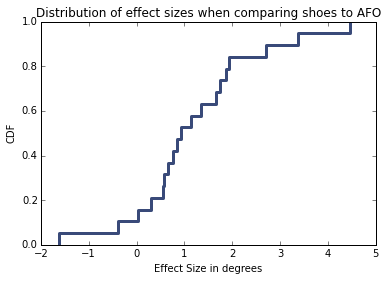

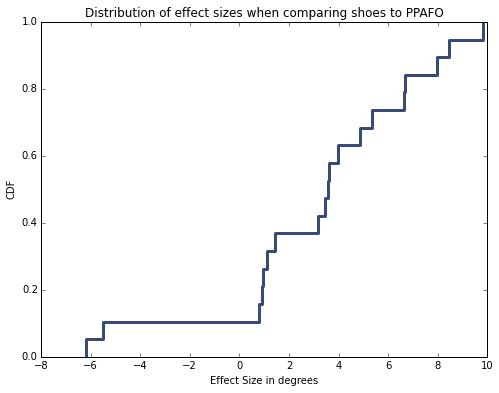

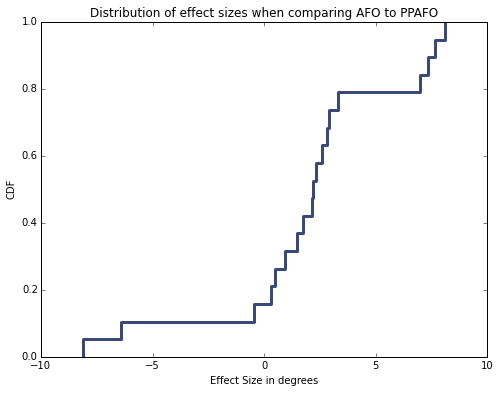

In [206]:
cdf1=thinkstats2.Cdf(shoesafo)
cdf2=thinkstats2.Cdf(shoesppafo)
cdf3=thinkstats2.Cdf(afoppafo)

thinkplot.Cdf(cdf1)
thinkplot.Show(legend=False, xlabel='Effect Size in degrees', ylabel='CDF', title='Distribution of effect sizes when comparing shoes to AFO')

thinkplot.Cdf(cdf2)
thinkplot.Show(legend=False, xlabel='Effect Size in degrees', ylabel='CDF', title='Distribution of effect sizes when comparing shoes to PPAFO')

thinkplot.Cdf(cdf3)
thinkplot.Show(legend=False, xlabel='Effect Size in degrees', ylabel='CDF', title='Distribution of effect sizes when comparing AFO to PPAFO')